# From PCA to the Subspace Method

In the example code of this tutorial, we assume for simplicity that the following symbols are already imported.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

import sys, os, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sys.path.insert(0, os.pardir)
import warnings
warnings.filterwarnings('ignore')

from cvt.models import SubspaceMethod

In this example we will start with principal component analysis (PCA) and work our way to classification with the subspace method (SM).

We will conduct the procedure in the following steps.

1. Prepare a dataset
2. Peform PCA on each class and select eigenvectors (Training)
3.  Calculate cosine similarities for each subspace (Classification)
4. Bad use case for SM
5. Good use case for SM

## 1. Prepare a dataset

Here we create a random set of data with 2 features.

The `make_classification` function generates data for a random n-class classification problem.

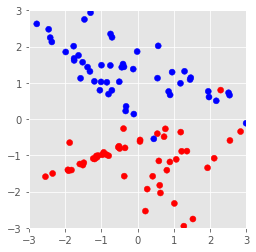

In [2]:
plt.style.use('ggplot')

# Create a random set of data of 2 dimensions
X, y = make_classification(n_features=2, n_redundant=0)

# Plot the dataset
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(*X.T, c=y,cmap=cm_bright)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.axes().set_aspect('equal')
plt.show()

## 2. Peform PCA on each class and select eigenvectors (Training)

In most cases of the subspace method, PCA is performed on each class to create subspaces. These subspaces are then used as references to determine the class of newly introduced data.

In this example, we have only 2 dimensions. Therefore we will choose a 1 dimensional subspace to use for classification.

This 1-dimensional subspace will determined with pca, so it will be the direction which captures the largest variance.

Eigen vectors from class 0:
[[-0.97085135 -0.23968241]]

Eigen vectors from class 1:
[[-0.69337618  0.7205758 ]]



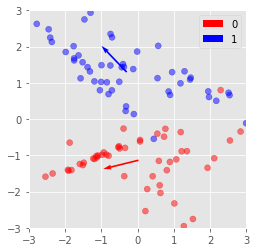

In [3]:
def pca(X, n_components):
    """
    Tip from https://stackoverflow.com/a/45435548
    
    np.eigh guarantees you that the eigenvalues are sorted and
    uses a faster algorithm that takes advantage of the fact
    that the matrix is symmetric. 
    If you know that your matrix is symmetric, use this function.
    """

    eig_vals, eig_vecs = np.linalg.eigh(X.T@X)
    return eig_vals[::-1][:n_components], eig_vecs[::-1][:n_components]

dct = {}
for c in range(2):
    Xc = X[np.where(y==c)]
    _, eig_vecs = pca(Xc, 1)
    
    # Store subspaces to use later for classification
    dct[c] = eig_vecs
    
    print(f'Eigen vectors from class {c:.0f}:\n{eig_vecs}\n')
    plt.quiver(*Xc.mean(axis=0), eig_vecs[0][0],eig_vecs[0][1], label=c,
               color=cm_bright(c), scale=1, angles='xy', scale_units='xy')
    
plt.scatter(*X.T, c=y, cmap=cm_bright, alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.axes().set_aspect('equal')
plt.legend()
plt.show()

## 3. Calculate cosine similarities for each subspace (Classification)

Next, to classify data we calculate the cosine similarities between the input vector and each subspace.

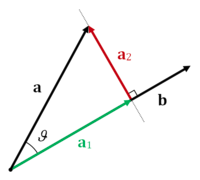

The cosine similarity can be interpreted as

- **The projection legngth from the input vector to the subspace**
- **The "angle" between the input vector and a subspace**

or if we change our perspective the cosine similarity is inversely related to 

- **The rejection legngth from the input vector to the subspace**

Below is an example using the subspaces calculated from the previous data.

Class 0: cosine similarity=0.731, angle=43.016, rejection length=0.965
Class 1: cosine similarity=1.414, angle=nan, rejection length=nan
test_x will be classified to 1


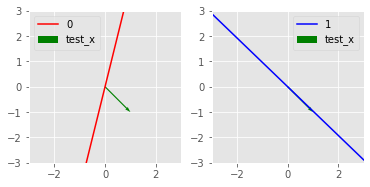

In [4]:
test_x = [1, -1]

fig, axs = plt.subplots(ncols=2)

for c, subspace in dct.items():
    m = subspace[0][0] / subspace[0][1]    
    xs = np.linspace(-3,3)
    ys = m * xs 
    
    # cos_sim = cos(θ)  
    # = (eigen_vec, test_x)/|eigen_vec||test_x|
    cos_sim = np.linalg.norm(dct[c] @ test_x)
    theta = np.arccos(cos_sim)
    dist = np.sin(theta) * np.linalg.norm(test_x)
    print(f'Class {c}: cosine similarity={cos_sim:.3f}, angle={np.rad2deg(theta):.3f}, rejection length={dist:.3f}')


    axs[c].quiver(0,0,*test_x, color='green', label='test_x', scale_units='xy',angles='xy',scale=1)
    axs[c].plot(xs, ys, color=cm_bright(c), label=c)
    axs[c].set_xlim(-3,3)
    axs[c].set_ylim(-3,3)
    axs[c].set_aspect('equal')
    axs[c].legend()
    
y_pred = 0 if np.linalg.norm(dct[0] @ test_x) > np.linalg.norm(dct[1] @ test_x) else 1
print(f'test_x will be classified to {y_pred}')
plt.show()

Now that we understand the subspace method, lets classify the data we used to generate the subspaces to see how well our classifier works.

In [5]:
score = 0

for i in range(len(X)):
    x = X[i]
    y_gt = y[i] # ground truth label
    
    # calculate projection distance to the
    # first classes subspace
    proj1 = np.linalg.norm(dct[0] @ x)

    # calculate projection distance to the 
    # second classes subspace
    proj2 = np.linalg.norm(dct[1] @ x)

    assert proj1 != proj2, 'Tie!'
    y_pred = 0 if proj1 > proj2 else 1
    
    score += 1 if y_pred == y_gt else 0
    
print(score / len(y))

0.62


The results do not look good.

Why could this be?

Let's have a look at the decision boundary to understand what is going on.

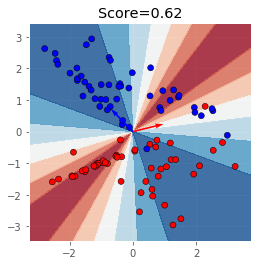

In [6]:
# This can be resused to visualize boundaries of other classifiers
def plot_decision_boundaries(clf, X, y, h=0.01, show=True):
    fig, ax = plt.subplots()
        
    # Build mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.scatter(*X.T, c=y, cmap=cm_bright, edgecolors='k')
    ax.set_title(f'Score={clf.score(X,y)}')
    
    if show:
        plt.show()
    else:
        return fig, ax
    
# Using the API provided in this package, we can easily create a subspace classifier.
def format_input(X, y):
    X = [X[np.where(y==t)] for t in np.unique(y)]
    return X, np.unique(y)

smc = SubspaceMethod(n_subdims=1, faster_mode=True)
smc.fit(*format_input(X, y))
smc.score(X, y)

fig, ax = plot_decision_boundaries(smc, X, y, show=False)

ax.set_aspect('equal')
ax.quiver(0,0,*smc.dic[0],angles='xy', scale_units='xy',scale=1, color='#FF0000')
ax.quiver(0,0,*smc.dic[1],angles='xy', scale_units='xy',scale=1, color='#0000FF')
plt.show()

As you can see, the subspace method is not very good with discriminating classes in a low dimensional space.

This is because the subspace method is "dimensionally hungry", it works much better in high dimensional data.

Many classification problems assume that the data given can be represented in a much lower dimension, the subspace method is a typical example.

Another point to make is that the subspace method works especially well on class that have a fundamentally different structure. On the otherhand it does not work when the structure of the distributions are similar.

In the next sections, I will give a bad use case for SM and a good use case.

## 4. Bad use case for SM

Here I will give a bad use case for SM. In essence they both have the same anti-pattern, that is, the generated subspaces are equal. Classification with subspaces becomes very difficult when the subspaces generated from pca are too similar.

An easy example on the 2 dimensional plane is when classes have data a distribution with the same covariance matrix.

Consider the following data:

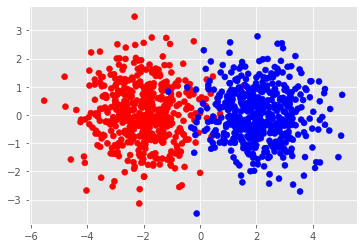

In [7]:
X_ = np.append(
    np.random.normal(loc=(-2, 0), size=(500, 2)),
    np.random.normal(loc=(2, 0), size=(500, 2)), axis=0)

y_ = np.append(
    np.zeros(500), 
    np.ones(500))

plt.scatter(*X_.T, c=y_, cmap=cm_bright)
plt.axes().set_aspect('equal')
plt.show()

If we conduct pca onto these distribution we should get a very similar eigenvectors.

In [8]:
for c in np.unique(y_):
    eig_vals, eig_vecs = pca(X_[np.where(y_==c)], 1)
    print(f'Eigen vectors from class {c:.0f}:\n{eig_vecs}\n')

Eigen vectors from class 0:
[[-0.99959599  0.02842293]]

Eigen vectors from class 1:
[[-0.99955934  0.02968376]]



Obviously the resulting classifier is not very good.

In [9]:
smc = SubspaceMethod(n_subdims=1, faster_mode=True)
smc.fit(*format_input(X_, y_))
smc.score(X_, y_)

0.524

## 5. Good use case for SM

The subspace method becomes more powerful in higher dimensions.

I will demonstrate this by generating toy data in high dimensions and apply the subspace method to it.

In [10]:
scores = []
n_subdims = []
for d in range(2, 100):
    X_, y_ = make_classification(n_samples=200, n_features=d, n_redundant=0)

    # Exhaustive search for the optimal subspace dimension
    max_score = (0, 0) # store n_subdims and score
    for n in range(1, d):
        smc = SubspaceMethod(n_subdims=n, faster_mode=True)
        smc.fit(*format_input(X_, y_))
        score = smc.score(X_, y_)
        max_score = (n, score) if max_score[1] < score else max_score
        
    n_subdims.append(max_score[0])
    scores.append(max_score[1])

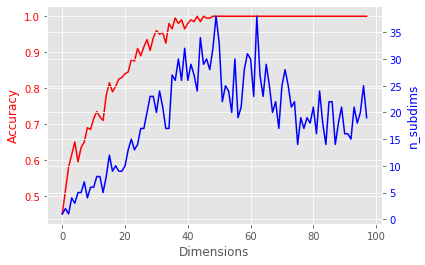

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(scores, color='red')
ax1.set_xlabel('Dimensions')
ax1.set_ylabel('Accuracy', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(n_subdims, color='blue', label='n_subdims')
ax2.set_ylabel('n_subdims', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()

## 6. Improving results

Although the subspace method does not suite low dimensions, there are still some tricks we can utilize to improve classification accuracy.
 
### Weighted-SM

Instead of choosing the subspace with PCA, we can use Latent Discriminant Analysis (LDA).

In [19]:
dct = {}
for c in range(2):
    Xc = X[np.where(y==c)]
    eig_vals, eig_vecs = pca(Xc, 2)
    
    eig_vals /= np.sum(eig_vals)
    
    # Store subspaces to use later for classification
    dct[c] = {'eig_vals':eig_vals, 'eig_vecs':eig_vecs}

def predict(x):
        
    # calculate projection distance to the
    # first classes affine space
    proj1 = dct[0]['eig_vals'] * dct[0]['eig_vecs'] @ x 
    proj1 = proj1.sum()
    
    # calculate projection distance to the 
    # second classes affine space
    proj2 = dct[0]['eig_vals'] * dct[1]['eig_vecs'] @ x 
    proj2 = proj2.sum()
    
    y_pred = 0 if proj1 > proj2 else 1
    if proj1 == proj2:
        y_pred = 2

    return y_pred

score = 0
y_preds = []
for i in range(len(X)): 
    y_preds.append(predict(X[i]))

print(accuracy_score(y, y_preds))

0.91


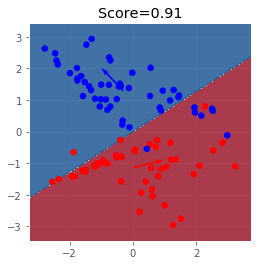

In [20]:
# Override smc decision func
fig, ax = plt.subplots()

# Build mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = []
for x in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(predict(x))

Z = np.array(Z)
    
# Put the result into a color plot
cm = plt.cm.RdBu
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(*X.T, c=y, cmap=cm_bright)
ax.set_title(f'Score={accuracy_score(y, y_preds)}')

ax.set_aspect('equal')

smc = SubspaceMethod(n_subdims=1, faster_mode=True)
smc.fit(*format_input(X, y))

ax.quiver(*X[y==0].mean(axis=0), *smc.dic[0],angles='xy', scale_units='xy',scale=1, color='#FF0000')
ax.quiver(*X[y==1].mean(axis=0), *smc.dic[1],angles='xy', scale_units='xy',scale=1, color='#0000FF')
plt.show()

### 6.1 Latent Discriminant Analysis (LDA)

Instead of choosing the subspace with PCA, we can use Latent Discriminant Analysis (LDA).

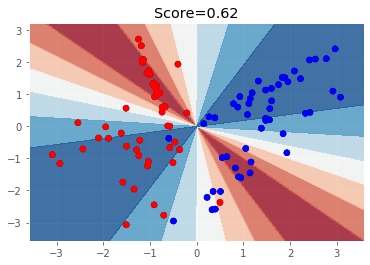

In [13]:
def lda(X, y, n_components):
    S_W = np.zeros((X.shape[1],X.shape[1]))
    S_B = np.zeros((S_W.shape))

    X_mean = X.mean(axis=0)
    for c in np.unique(y):
        Xc = X[np.where(y==c)]
        Xc_mean, n = X[y==c].mean(axis=0), len(Xc)

        S_W += np.sum([np.outer(x-Xc_mean,x-Xc_mean) for x in Xc], axis=0)    
        S_B += n * np.outer(Xc_mean - X_mean, Xc_mean - X_mean)
    
    eig_vals, eig_vecs = np.linalg.eigh(np.linalg.inv(S_W).dot(S_B))
    return eig_vals[::-1][:n_components], eig_vecs[::-1][:n_components]


_, eig_vecs = lda(X, y, 2)
X_lda = (eig_vecs@X.T).T

smc = SubspaceMethod(n_subdims=1, faster_mode=True)
smc.fit(*format_input(X_lda, y))

fig, ax = plot_decision_boundaries(smc, X_lda, y, show=False)

plt.scatter(*(eig_vecs@X.T), c=y, cmap=cm_bright)
plt.show()

didn't really work did it..

### 6.2 Affine Space Projection

A reason that classification becomes difficult in lower dimensions is that the structural differences do not differ so much. 

Subspaces are defined to go through the origin and therefore, it is invariant to changes in the mean.

Taking away this constraint, e.g. projecting to affine spaces, may help classification in some situations.

In [14]:
X.shape

(100, 2)

In [17]:
from numpy import arccos, array, dot, pi, cross
from numpy.linalg import det, norm

# from: https://gist.github.com/nim65s/5e9902cd67f094ce65b0
def distance_numpy(A, B, P):
    """ segment line AB, point P, where each one is an array([x, y]) """
    if all(A == P) or all(B == P):
        return 0
    if arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > pi / 2.:
        return norm(P - A)
    if arccos(dot((P - B) / norm(P - B), (A - B) / norm(A - B))) > pi / 2.:
        return norm(P - B)
    return norm(cross(A-B, A-P))/norm(B-A)

def predict(x):
    x0_mean =  X[y==0].mean(axis=0)
    x1_mean =  X[y==1].mean(axis=0)
    origin=np.zeros(2)
    aff0 = (dct[0] + x0_mean).reshape(2)
    aff1 = (dct[1] + x1_mean).reshape(2)
    x=x.reshape(2)
        
    # calculate projection distance to the
    # first classes affine space
    proj1 = aff0 @ x 
    proj1 = distance_numpy(origin, aff0, x)

    # calculate projection distance to the 
    # second classes affine space
    proj2 = aff1 @ x 
    proj2 = distance_numpy(origin, aff1, x)

    y_pred = 0 if proj1 < proj2 else 1
    if proj1 == proj2:
        y_pred = 2

    return y_pred

score = 0
y_preds = []
for i in range(len(X)): 
    y_preds.append(predict(X[i]))

print(accuracy_score(y, y_preds))

TypeError: unsupported operand type(s) for +: 'dict' and 'float'

※ Experimental Decision Boundary Viz


TypeError: unsupported operand type(s) for +: 'dict' and 'float'

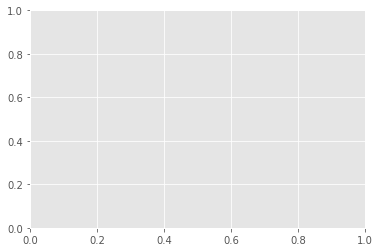

In [18]:
# Override smc decision func
fig, ax = plt.subplots()

# Build mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = []
for x in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(predict(x))

Z = np.array(Z)
    
# Put the result into a color plot
cm = plt.cm.RdBu
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(*X.T, c=y, cmap=cm_bright)
ax.set_title(f'Score={accuracy_score(y, y_preds)}')

ax.set_aspect('equal')

smc = SubspaceMethod(n_subdims=1, faster_mode=True)
smc.fit(*format_input(X, y))

ax.quiver(*X[y==0].mean(axis=0), *smc.dic[0],angles='xy', scale_units='xy',scale=1, color='#FF0000')
ax.quiver(*X[y==1].mean(axis=0), *smc.dic[1],angles='xy', scale_units='xy',scale=1, color='#0000FF')
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(*X.T, c=y_preds)
ax.set_title(f'Score={score}')

ax.set_aspect('equal')

smc = SubspaceMethod(n_subdims=1, faster_mode=True)
smc.fit(*format_input(X, y))

ax.quiver(*X[y==0].mean(axis=0), *smc.dic[0],angles='xy', scale_units='xy',scale=1, color='#FF0000')
ax.quiver(*X[y==1].mean(axis=0), *smc.dic[1],angles='xy', scale_units='xy',scale=1, color='#0000FF')
plt.show()

In [ ]:
y_preds[y_preds==2]